<a href="https://colab.research.google.com/github/lilianabs/nlp-basics/blob/main/Simple_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-02-10 17:02:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-10 17:02:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-10 17:02:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [35]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import LSTM, SimpleRNN, Embedding
from keras.utils import pad_sequences

In [36]:
df = pd.read_csv('IMDB Dataset.csv')

In [37]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data preparation

In [38]:
def preprocess_text(sen):
  # Remove Stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  sen = pattern.sub('', sen)

  # Remove html tags
  sen = re.sub(r'<[^>]+>', ' ', sen)

  # Remove punctuations and numbers
  sen = re.sub(r'[^\w\s]', ' ', sen)

  # Remove single characters
  sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen)

  # Remove multiple spaces
  sen = re.sub(r'\s+', ' ', sen)

  # Lowercase
  sen = sen.lower()

  return sen

In [39]:
X = []
sentences = list(df['review'])

for sen in sentences:
  X.append(preprocess_text(sen))

In [40]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, df['sentiment'])))

In [41]:
X[1]

'a wonderful little production the filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece the actors extremely well chosen michael sheen got polari voices pat you truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life the realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears it plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

In [42]:
len(X[1])

678

In [43]:
# Tokenize words into numerical sequences
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)

In [44]:
len(X[1])

92

In [45]:
vocab_lenght = len(word_tokenizer.word_index) + 1

In [46]:
vocab_lenght

101696

In [47]:
# Padding
max_len = 100

X = pad_sequences(X, padding='post', maxlen=max_len)

In [48]:
X[1]

array([  562,   302,    46,   262,     1,  1295,  2914, 17675,    71,
           9,  2185,  1497,   321, 13240,   444, 25698,   189,  1761,
         351,   322,     1,    66,   476,    15,  2202,   398,  4116,
         100, 63085,  2219,  3222,    96,   279,    14, 13241,   697,
        9708,  1758,  1654,  7311,  6578,    15,   185,    65, 36440,
         316,  2328,   322,  4285,   262,     4,    20,  1057,   110,
          41,     1,  1761,    13,   179,   251,    46,    88,   933,
        2825,   159,   268,  2124,   879,  3071,  1197,  1101,  4885,
           6,   207,  1757,  4511,   491,    59,  3646, 18574, 24663,
         636,   491,   962, 24663, 44259, 26908,    83,  2222,  1895,
          15,   128,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Create embedding matrix

In [50]:
embeddings_dict = dict()
glove_file = open('glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions

glove_file.close()

In [51]:
len(embeddings_dict)

400000

In [52]:
embedding_matrix = np.zeros((vocab_lenght, 100))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [53]:
embedding_matrix.shape

(101696, 100)

## RNN model

In [55]:
rnn = Sequential()
embedding_layer = Embedding(vocab_lenght, 100, weights=[embedding_matrix],
                            input_length=max_len, trainable=False)

rnn.add(embedding_layer)
rnn.add(SimpleRNN(128))

rnn.add(Dense(1, activation='sigmoid'))

In [56]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          10169600  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10,199,041
Trainable params: 29,441
Non-trainable params: 10,169,600
_________________________________________________________________


In [58]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [59]:
# Train the rnn model
rnn_history = rnn.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 41s 154ms/step - loss: 0.6552 - acc: 0.6109 - val_loss: 0.6868 - val_acc: 0.5441
Epoch 2/10
250/250 [==============================] - 54s 217ms/step - loss: 0.6594 - acc: 0.6086 - val_loss: 0.6739 - val_acc: 0.5509
Epoch 3/10
250/250 [==============================] - 40s 158ms/step - loss: 0.6662 - acc: 0.5841 - val_loss: 0.6818 - val_acc: 0.5484
Epoch 4/10
250/250 [==============================] - 45s 179ms/step - loss: 0.6665 - acc: 0.5769 - val_loss: 0.6724 - val_acc: 0.5598
Epoch 5/10
250/250 [==============================] - 42s 169ms/step - loss: 0.6612 - acc: 0.5907 - val_loss: 0.6713 - val_acc: 0.5571
Epoch 6/10
250/250 [==============================] - 39s 154ms/step - loss: 0.6705 - acc: 0.5711 - val_loss: 0.6762 - val_acc: 0.5512
Epoch 7/10
250/250 [==============================] - 46s 182ms/step - loss: 0.6616 - acc: 0.5739 - val_loss: 0.6348 - val_acc: 0.6094
Epoch 8/10
250/250 [==============================] - 4

In [60]:
rnn_score = rnn.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy: ", rnn_score[1])

313/313 [==============================] - 6s 20ms/step - loss: 0.6616 - acc: 0.5882
Test Accuracy:  0.5881999731063843


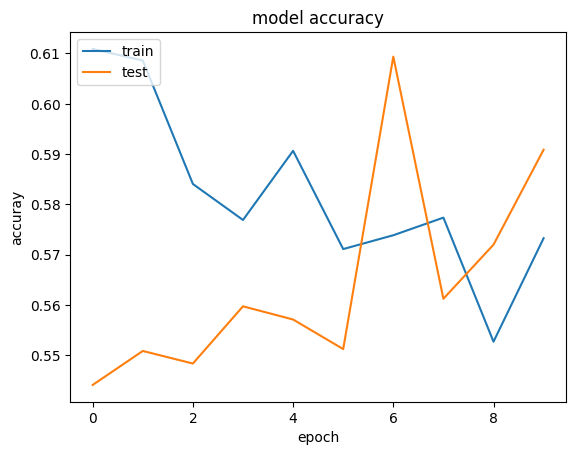

In [61]:
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuray')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

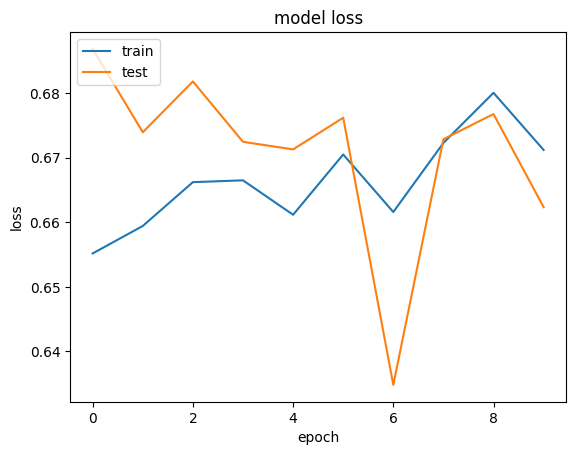

In [62]:
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## LSTM model

In [63]:
lstm = Sequential()

embedding_layer = Embedding(vocab_lenght, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)

lstm.add(embedding_layer)
lstm.add(LSTM(128))

lstm.add(Dense(1, activation='sigmoid'))

In [64]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          10169600  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,286,977
Trainable params: 117,377
Non-trainable params: 10,169,600
_________________________________________________________________


In [65]:
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

lstm_history = lstm.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 134s 508ms/step - loss: 0.5073 - acc: 0.7554 - val_loss: 0.4245 - val_acc: 0.8079
Epoch 2/10
250/250 [==============================] - 131s 522ms/step - loss: 0.4179 - acc: 0.8118 - val_loss: 0.3810 - val_acc: 0.8301
Epoch 3/10
250/250 [==============================] - 122s 491ms/step - loss: 0.3758 - acc: 0.8351 - val_loss: 0.3418 - val_acc: 0.8531
Epoch 4/10
250/250 [==============================] - 134s 539ms/step - loss: 0.3382 - acc: 0.8546 - val_loss: 0.3264 - val_acc: 0.8640
Epoch 5/10
250/250 [==============================] - 125s 500ms/step - loss: 0.3193 - acc: 0.8660 - val_loss: 0.3230 - val_acc: 0.8597
Epoch 6/10
250/250 [==============================] - 125s 499ms/step - loss: 0.2952 - acc: 0.8766 - val_loss: 0.3306 - val_acc: 0.8568
Epoch 7/10
250/250 [==============================] - 123s 490ms/step - loss: 0.2825 - acc: 0.8835 - val_loss: 0.3454 - val_acc: 0.8572
Epoch 8/10
250/250 [============================

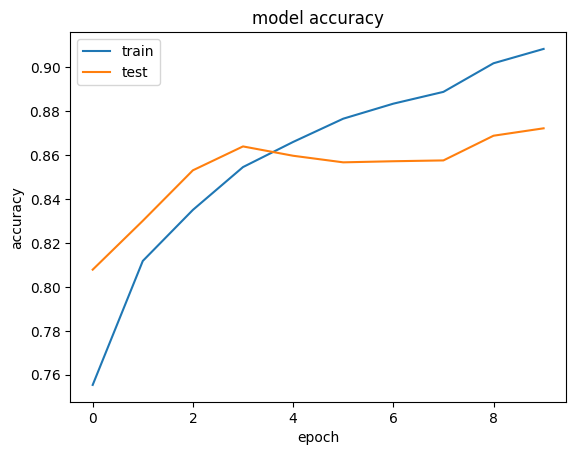

In [66]:
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

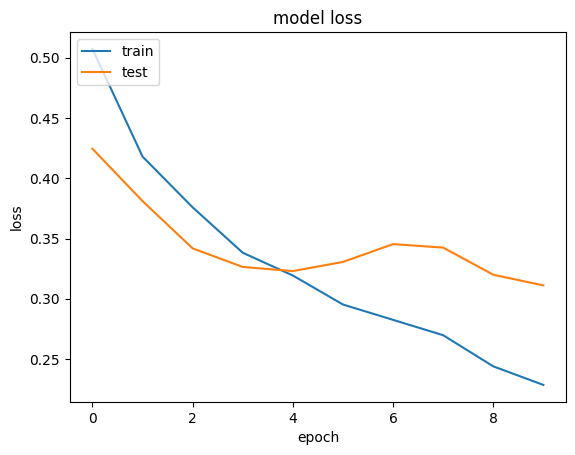

In [67]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()